In [1]:
from info import * 
from preprocess import *
from utils import *

import sys

# TODO: automatic unit testing
# sys.path.insert(0, '/Users/matty_gee/Dropbox/Projects/social_navigation_task/tests')
# %run -i '../tests/test_behavior.py'

/Users/matthew/opt/anaconda3/envs/social_navigation_task/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/matthew/opt/anaconda3/envs/social_navigation_task/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


# Coordinates w/in a trajectory, or across trajectories

In [2]:
# TODO speedup: parallelize?
# TODO: use more decorators, generators
# TODO: think way more about data types and how to opimitize, protect against errors etc...
# TODO: better ways to data type: automatically? 
# TODO: compare aganst previous class
# TODO: need an ANGLE consistency variable...?
# TODO: figure caching out #@lru_cache(maxsize=12)

import sys
import cProfile
from functools import wraps, lru_cache
from warnings import simplefilter

from numpy import asarray, linalg
import numpy.lib.recfunctions as rfn
from scipy.spatial import ConvexHull, Delaunay, procrustes
from shapely.geometry import Polygon
import pycircstat

from info import * 
from preprocess import *
from utils import *

In [4]:
# TODO: speed this up!

def _coincident_vectors(u, v):
    ''' Checks if vectors (u & v) are the same or scalar multiples of each other'''
    return np.dot(u, v) * np.dot(u, v) == np.dot(u, u) * np.dot(v, v)


def angle_between_vectors(u, v, direction=None, verbose=False):
    '''
        Compute elementwise angle between sets of vectors u & v
            
        uses np.arctan2(y,x) which computes counterclockwise angle [-π, π] between origin (0,0) and x, y
        clockwise v. counterclockwise: https://itecnote.com/tecnote/python-calculate-angle-clockwise-between-two-points/  
        included: ADD LINK

        TODO: make pairwise..?

        Arguments
        ---------
        u : array-like
            vector
        v : array-like
            another vector
        direction : None, True or False (optional, default=None)
            None == Included
            True == Clockwise 360
            False == Counterclockwise 360 
        verbose : bool (optional, default=False)
             
        Returns
        -------
        float 
            angle in radians 

        [By Matthew Schafer; github: @matty-gee; 2020ish]
    '''

    #     if U.shape != V.shape:
    #         if verbose: print(f'Different shape vectors: U={U.shape}, V={V.shape}. Assuming smaller is reference.')
    #         if len(U) < len(V): U = np.repeat(np.expand_dims(U, 0), len(V), axis=0)
    #         else:               V = np.repeat(np.expand_dims(V, 0), len(U), axis=0)
    #     rads = []
    #     for u, v in zip(U, V):        
    # 
    #     
    # if one of vectors is at origin, the angle is undefined but could be considered as orthogonal (90 degrees)
    if ((u==0).all()) or ((v==0).all()): 
        if verbose: print(u, v, 'at least 1 vector at origin; treating as orthogonal')
        rad = np.pi/2

    # if same vectors (or scalar multiples of each other) being compared, no angle between (0 degrees)
    # -- b/c 0-360 degrees, direction matters: make sure the signs are the same too
    elif (_coincident_vectors(u, v)) & all(np.sign(u) == np.sign(v)):
        if verbose: print(u, v, 'same vectors, no angle in between')
        rad = 0 # 0 degrees == 360 degrees == 2*pi radians 

    else:

        if direction is None: 

            # "included" angle from [0,180], [0, π] 
            rad = np.arccos(np.dot(u, v) / (linalg.norm(u) * linalg.norm(v)))
            # equivalent: np.arctan2(l2_norm(np.cross(u, v)), np.dot(u, v))

        elif direction is True: 

            # clockwise angle from [0,360], [0, 2π]
            # -- compute vector angles from origin & take difference, then convert to 360 degrees
            rad = (np.arctan2(*v[::-1]) - np.arctan2(*u[::-1])) % (2 * np.pi)  
        
        elif direction is False:

            # counterclockwise angle from [0,360], [0, 2π]
            # -- compute vector angles from origin & take difference, then convert to 360 degrees
            rad = (np.arctan2(*u[::-1]) - np.arctan2(*v[::-1])) % (2 * np.pi)
            
    return rad


def calculate_angle(U, V=None, direction=None, force_pairwise=True, verbose=False):
    '''
        Calculate angles between n-dim vectors 
        If V == None, calculate U pairwise
        Else, calculate elementwise
        
        TODO: more explanation; find more elegant ways to do this; also adapt other pairwise like functions to have structure

        Arguments
        ---------
        U : array-like
            shape (n_vectors, n_dims)
        V : array-like
            shape (n_vectors, n_dims)
        direction : optional (default=None)
            None : included 180
            False : counterclockwise 360 (wont give a symmetrical matrix)
            True : clockwise 360
            
        Returns
        -------
        numeric 
            pairwise angles in radians

        [By Matthew Schafer; github: @matty-gee; 2020ish]
    '''
    
    # # testing (10-12-22)
    # U = np.random.randint(100, size=(4,2))
    # for V in [None, np.random.randint(100, size=U.shape), 
    # np.random.randint(100, size=(1, U.shape[1])), np.random.randint(100, size=(7, U.shape[1]))]:

    messages = []

    # check/fix shapes
    if U.ndim == 1: 
        U = np.expand_dims(U, 0)
        messages.append('Added a dimension to U')
        
    if V is not None:
        if V.ndim == 1: 
            V = np.expand_dims(V, 0)
            messages.append('Added a dimension to V')

            
    # determine output shape 
    # - 1 set of vectors: pw, square, symm
    if V is None: 
        default = 'pairwise'
        V = U 
        
    # - 2 vectors of same shape
    # -- pw, square, non-symm
    # -- ew, vector
    elif U.shape == V.shape: 
        default = 'elementwise' 

    # - 2 vectors, 1 w/ length==1 & is reference
    # -- pw, vector shape (1,u)
    elif (U.shape[0] > 1) & (V.shape[0] == 1): 
        V = np.repeat(V, len(U), 0) 
        default = 'reference'  
    
    # -- pw, vector shape (v,1)
    elif (U.shape[0] == 1) & (V.shape[0] > 1): 
        U = np.repeat(U, len(V), 0) 
        default = 'reference' 
        
    # - 2 vectors, different lengths
    # -- pw, rectangle 
    else: 
        default = 'pairwise' 
        
    messages.append(f'Calculated {default}')
    
    
    # calculate angles
    # if pairwise dont have to compute every angle.. but gotta be careful abouyt symmetric and not 
    radians = np.zeros((U.shape[0], V.shape[0]))
    for i in range(U.shape[0]):
        for j in range(V.shape[0]):
            radians[i, j] = angle_between_vectors(U[i,:], V[j,:], direction=direction)

            
    # output
    if default == 'pairwise': cols = 'U'
    else:                     cols = 'V'
    radians = pd.DataFrame(radians, index=[f'U{i+1:02d}' for i in range(len(U))], columns=[f'{cols}{i+1:02d}' for i in range(len(V))])

    if not force_pairwise:
        if default == 'reference':
            radians = radians.iloc[:,0].values
        elif default == 'elementwise':
            radians = np.diag(radians)
    if verbose: [print(m) for m in messages]
        
    return radians


# data = pd.read_excel(example_org_file)
# coords = data[['affil','power']].values
# ref = np.array([6,0])
# calculate_angle(coords, ref, force_pairwise=False, direction=None)
# cProfile.run("calculate_angle(coords, ref, force_pairwise=False, direction=None)")

In [44]:
from numba import njit
class ComputeBehavior2:

    __slots__ = ["file_path", "sub_id", "data",
                 "decision_types", "weight_types", "coord_types",  
                 "demean_coords", "dfs"] # assign now to optimize memory

    def __init__(self, file, decision_types=False, weight_types=False, coord_types=False, demean_coords=False):
        '''
            Class to compute behavioral geometry

            Arguments
            ---------
            file : str, dataframe or None
                
            decision_types : bool (optional, default=False)
                'current'
                'previous' 
            weight_types : bool (optional, default=False)
                'constant'
                'linear_decay'
                'exponential_decay'
            coord_types : bool (optional, default=False)
                'actual'
                'counterfactual' 
            demean_coords : bool (optional, default=False)
                if True, mean centers the coordinates  

            Raises
            ------
            Exception : 
                _description_

        '''
    
        simplefilter(action="ignore", category=pd.errors.PerformanceWarning) # fragmented df...TODO maybe fix??
        np.seterr(divide='ignore', invalid='ignore') # division by 0 in some of our operations
            
        #---------------------------------------------------------------
        # load in data
        #---------------------------------------------------------------
        
        if file is None:

            self.file_path = None
            self.sub_id    = None   

        else:

            if type(file) is not str: # eg for easy unittesting
                
                self.file_path = None
                self.sub_id    = None
                self.data      = copy.deepcopy(file)
            
            else: 
                
                self.file_path = Path(file)
                self.sub_id    = self.file_path.stem.split('_')[1] # expects a filename like 'snt_subid_*'
                if self.file_path.suffix == '.xlsx':  self.data = copy.deepcopy(pd.read_excel(self.file_path, engine='openpyxl'))
                elif self.file_path.suffix == '.xls': self.data = copy.deepcopy(pd.read_excel(self.file_path))
                elif self.file_path.suffix == '.csv': self.data = copy.deepcopy(pd.read_csv(self.file_path))
                else: raise Exception(f'File type {self.file_path.suffix} not recognized')
    
                self.check_input(self.data, (63, self.data.shape[1])) # should have 63 trials
 
            #---------------------------------------------------------------
            # clean up input
            #---------------------------------------------------------------
            
            # get decisions in 2d
            if 'affil' not in self.data.columns: # for backward compatability
                self.data['decision'] = self.data['decision'].astype(int)
                dim_mask  = np.vstack([(self.data['dimension'] == 'affil').values, 
                                       (self.data['dimension'] == 'power').values]).T
                self.data[['affil', 'power']] = self.data['decision'].values[:, np.newaxis] * (dim_mask * 1)
                            
            # TODO: maybe should already convert into a numpy structured array?
            # ensure correct data types
            type_dict = {'decision_num': int, 'scene_num': int, 'dimension': object,
                         'char_role_num': int, 'char_decision_num': int,
                         'button_press': int, 'decision': int, 'affil': int, 'power': int,
                         'reaction_time': float, 'onset': float}
            for col in self.data: 
                if self.data[col].dtype != type_dict[col]:
                    self.data[col] = self.data[col].astype(type_dict[col])

        #---------------------------------------------------------------
        # what to compute
        #---------------------------------------------------------------

        # types of decisions, weighting, coordinates
        if decision_types is True:    self.decision_types = ['current', 'previous']
        elif decision_types is False: self.decision_types = ['current']
        else:                         self.decision_types = decision_types
        
        if weight_types is True:      self.weight_types = ['constant', 'linear_decay', 'exponential_decay']
        elif weight_types is False:   self.weight_types = ['constant']
        else:                         self.weight_types = weight_types
        
        if coord_types is True:       self.coord_types = ['actual', 'counterfactual']
        elif coord_types is False:    self.coord_types = ['actual']
        else:                         self.coord_types = coord_types

        self.demean_coords = demean_coords

    @staticmethod
    def check_input(input, exp_shapes):
        ''' check the shape of input arrays'''
        if type(exp_shapes) != list: exp_shapes = [exp_shapes]
        matches = np.sum([input.shape == e for e in exp_shapes])
        if matches == 0:
            str_ = (' ').join([f'({e[0]},{e[1]})' for e in exp_shapes])
            raise Exception(f'Shape mismatch: {input.shape}!= any of expected shapes: {str_}')
        else:
            return True

    #---------------------------------------------------------------------------------------
    # defining the trajectories in cartesian and polar coordinates
    #---------------------------------------------------------------------------------------
    
    @staticmethod
    def get_decisions(decisions_raw, which='current', shift_by=1, replace_with=0, float_dtype='float32'):
        '''
            _summary_

            Arguments
            ---------
            decisions_raw : _type_
                _description_
            which : str (optional, default='current')
                _description_ 
            shift_by : int (optional, default=1)
                _description_ 
            replace_with : int (optional, default=0)
                _description_ 

            Returns
            -------
            _type_ 
                _description_

        '''
        if which == 'current':
            return np.array(decisions_raw, dtype=float_dtype)
        elif which == 'previous':
            decisions_prev = np.ones_like(decisions_raw) * replace_with
            decisions_prev[shift_by:] = np.array(decisions_raw)[0:-shift_by]
            return np.array(decisions_prev, dtype=float_dtype)

    @staticmethod
    def weight_decisions(decisions, weights='constant', float_dtype='float32'):
        '''
            _summary_

            Arguments
            ---------
            decisions : _type_
                _description_
            weights : str (optional, default='constant')
                _description_ 
        '''
        n_trials = len(decisions)
        if weights == 'constant': 
            decisions_weighted = decisions * np.ones(n_trials)[:,None]
        elif weights == 'linear_decay': 
            decisions_weighted = decisions * utils.linear_decay(1, 1/n_trials, n_trials)[:,None]
        elif weights == 'exponential_decay': 
            decisions_weighted = decisions * utils.exponential_decay(1, 1/n_trials, n_trials)[:,None]
        return np.array(decisions_weighted, dtype=float_dtype)

    @staticmethod
    def get_coords(decisions, which='actual', demean=False, float_dtype='float32'):
        '''
            _summary_

            Arguments
            ---------
            decisions : array of shape (n_trials, 2)
            which : str (optional, default='actual')
                'actual' or 'counterfactual' 
            demean : bool (optional, default=False)
                whether to demean coordinates or not 

            Returns
            -------
            _type_ 
                _description_
        '''
        if which == 'actual':
            coords = np.cumsum(decisions, axis=0)
        elif which == 'counterfactual':
            coords = (np.cumsum(decisions, axis=0) - (2*decisions))
        if demean: coords = coords - np.mean(coords, axis=0)
        return np.array(coords, dtype=float_dtype)

    @staticmethod
    def make_3d(U, V, ori):
        ''' 
            add 3rd dimension to vector arrays U & V & origin coordinates
            - U are vectors of interest, z-axis will vary w/ number of interactions
            - ori will be subtracted from U, z-axis will vary w/ number of interactions
            - V are reference vectors, z-axis is constant
        '''

        if V.ndim == 2:   V = V[0]
        if ori.ndim == 1: ori = ori[np.newaxis]

        num = np.arange(1, len(U) + 1)[:,np.newaxis]
        U   = np.concatenate([U, num], axis=1) # changes w/ num of interactions
        V   = np.repeat(np.hstack([V, len(U)])[np.newaxis], len(U), axis=0) # fixed
        ori = np.concatenate([np.repeat(ori, len(U), axis=0), num], axis=1) # changes w/ num of interactions   

        return U, V, ori                           
 
        ''' 

        '''
          
    @staticmethod
    def calc_angle(coords, ref_frame, n_dim=2, float_dtype='float32'):
        '''
            _summary_

            Arguments
            ---------
            coords : _type_
                _description_
            ref_frame : _type_
                _description_
            n_dim : int (optional, default=2)
                _description_ 

            Returns
            -------
            angles array  
            
            - origin
            --- neu: (0, 0, [interaction # (1:12)]) - note that 'origin' moves w/ interactions if in 3d
            --- pov: (6, 0, [interaction # (1:12)])
            - reference vector (ref_vec)
            --- neu: (6, 0, [max interaction (12)])
            --- pov: (6, 6, [max interaction (12)])
            - point of interaction vector (poi): (curr. affil coord, power coord, [interaction # (1:12)])
            to get directional vetctors (poi-ori), (ref-ori)
            - angle direction 
        '''

        ref, ori, drn = ref_frame['ref_vec'], ref_frame['origin'], ref_frame['angle_drn']
       
        if n_dim == 3: 
            coords, ref, ori = ComputeBehavior2.make_3d(coords, ref[0], ori)
            drn = None # may not be correct for neutral origin... not sure yet

        return np.array(calculate_angle(coords-ori, ref-ori, force_pairwise=False, direction=drn), dtype=float_dtype)[:, np.newaxis] # maybe add this into this class?

    @staticmethod
    def calc_distance(coords, origin, float_dtype='float32'):
        return np.array([linalg.norm(v) for v in coords-origin], dtype=float_dtype)[:, np.newaxis]

    #---------------------------------------------------------------------------------------
    # other geometry
    #---------------------------------------------------------------------------------------

    # TODO: figure out to use decorator w/ generator expression instread of list comprehension
    @staticmethod
    def cumulative(func):
        ''' decorator to compute measures cumulatively '''
        @wraps(func)
        def wrapper(values):
            return np.vstack([func(values[:v, :]) for v in range(len(values))])
        return wrapper

    @staticmethod
    def simulate_consistent_decisions(decisions, float_dtype='float32'):
        ''' 
            generate perfectly consistent and perfectly inconsistent decisions given a decision pattern
        '''
        resp_mask  = abs(decisions) 
        con_decs   = resp_mask * 1
        incon_decs = np.zeros_like(resp_mask)
        for n_dim in range(2): 
            dim_mask = resp_mask[:, n_dim] != 0 
            incon_decs[dim_mask, n_dim] = [n if not i % 2 else -n for i, n in enumerate(con_decs[dim_mask, n_dim])] # flip every other sign
        return [np.array(incon_decs, dtype=float_dtype), np.array(con_decs, dtype=float_dtype)]

    @staticmethod
    def calc_cumulative_consistency(decisions, float_dtype='float32'):
        '''
            _summary_

            Arguments
            ---------
            decisions : _type_
                _description_
            float_dtype : str (optional, default='float32')
                _description_ 

            Returns
            -------
            _type_ 
                _description_

        '''
        
        # simulate possible behavior
        resp_mask = np.abs(decisions)
        [incon_decs, con_decs] = ComputeBehavior2.simulate_consistent_decisions(decisions)  
        min_coords = np.cumsum(incon_decs, axis=0) / np.cumsum(resp_mask, axis=0) # adjust for response counts at each time point
        max_coords = np.cumsum(con_decs, axis=0) / np.cumsum(resp_mask, axis=0)

        # 1d consistency = abs value coordinate, scaled by min and max possible coordinate  
        cum_mean         = ComputeBehavior2.calc_cumulative_tendency(decisions, resp_mask, 'linear')
        consistency_cart = (np.abs(cum_mean) - min_coords) / (max_coords - min_coords) # min max scaled

        # 2d consistency = decision vector length, scaled by min and max possible vector lengths
        min_r, max_r  = (np.array([linalg.norm(v) for v in min_coords]), np.array([linalg.norm(v) for v in max_coords]))
        cum_mean_r    = np.array([linalg.norm(v) for v in cum_mean])
        consistency_r = ((cum_mean_r - min_r) / (max_r - min_r))[:, np.newaxis]
        
        # return both dimensions separately & 2d
        return np.hstack([consistency_cart, consistency_r], dtype=float_dtype) # TODO: think about - not forcing dtype during the actual computation jut at end...

    @staticmethod
    def calc_convexhull_polygon(coords):
        ''' helper function for calc_size & calc_quadrant_overlap 
            returns convexhull vertices & polygon from a set of 2D coordinates
        '''
        convexhull = ConvexHull(coords) 
        vertices   = coords[convexhull.vertices]
        return [geometry.Polygon(vertices), vertices]

    @staticmethod
    def calc_shape_metrics(coords, float_dtype="float32"):
        quad_vertices = np.array([[[0,0], [6,0], [6,6],  [0,6]],
                                [[-6,0],[0,0], [0,6],  [-6,6]],
                                [[0,0], [-6,0],[-6,-6],[0,-6]],
                                [[6,0], [0,0], [0,-6], [6,-6]]])
        try: 
            convexhull = ConvexHull(coords) 
            area       = convexhull.area # 2d this is perimeter
            volume     = convexhull.volume # 2d this is area
            polygon    = geometry.Polygon(coords[convexhull.vertices])
            overlap    = [polygon.intersection(geometry.Polygon(v)).area / area for v in quad_vertices]
            return np.array([area, volume] + overlap, dtype=float_dtype)
        except:
            return np.array([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan], dtype=float_dtype)

    @staticmethod
    def calc_centroid(coords, float_dtype='float32'):
        try: 
            return asarray(Polygon(coords).centroid.coords, dtype=float_dtype)
        except: 
            return np.array([np.nan, np.nan], dtype=float_dtype)

    @staticmethod
    def calc_cumulative_mean(values, resp_mask=None, which='linear', float_dtype='float32'):  
        if resp_mask is None: resp_mask = np.abs(values)
        if values.ndim == 1: values = values[:,np.newaxis] # or broadcast?
        if resp_mask.ndim == 1: resp_mask = resp_mask[:,np.newaxis]

        if which == 'linear':
            return np.array(np.cumsum(values, axis=0) / 
                            np.cumsum(resp_mask, axis=0), dtype=float_dtype)
        elif which == 'circular':
            means = np.zeros_like(values, dtype=float_dtype)
            for c in range(len(values)):
                if resp_mask[c]: means[c] = pycircstat.mean(values[:c])
                else:            means[c] = means[c-1] # replace w/ previous (or nan?)
            return np.array(means, dtype=float_dtype)

    #---------------------------------------------------------------------------------------
    # run stuff
    #---------------------------------------------------------------------------------------

    @staticmethod
    def calc_trajectory(indices, data, decisions='current', weights='constant', coords='actual', demean_coords=False, float_dtype='float32'):
        
        # TODO better way to do indices?

        # data & response masks
        resp_mask = (data['button_press'] != 0).values[:, np.newaxis]

        # cartesian coordinates
        decisions_raw      = data[['affil', 'power']].values
        decisions_selected = ComputeBehavior2.get_decisions(decisions_raw, which=decisions)
        decisions_weighted = ComputeBehavior2.weight_decisions(decisions_selected, weights=weights) 
        coordinates        = ComputeBehavior2.get_coords(decisions_weighted, which=coords, demean=demean_coords)

        # TODO: polar coordinates - add as a @staticmethod?
        ref_frames = {'neu': {'origin': np.array([[0,0]]), 'ref_vec': np.array([[6,0]]), 'angle_drn': False},
                      'pov': {'origin': np.array([[6,0]]), 'ref_vec': np.array([[6,6]]), 'angle_drn': None}} 
        angles, distances = [], []
        for origin in ['neu', 'pov']:
            distances.append(ComputeBehavior2.calc_distance(coordinates, ref_frames[origin]['origin'])) 
            for n_dim in [2, 3]:
                angles.append(ComputeBehavior2.calc_angle(coordinates, ref_frames[origin], n_dim=n_dim))      

        # TODO: maybe just output structured arrays from the staticmethods?
        trajectory = np.hstack([indices[:,np.newaxis], resp_mask, decisions_weighted, coordinates] + distances + angles)
        trajectory = rfn.unstructured_to_structured(trajectory, np.dtype([('index', 'uint16'), ('responded', 'bool'), ('affil_decision', float_dtype), ('power_decision', float_dtype),
                                                                          ('affil_coord', float_dtype), ('power_coord', float_dtype), ('neu_distance', float_dtype), ('pov_distance', float_dtype),
                                                                          ('neu2d_angle', float_dtype), ('neu3d_angle', float_dtype), ('pov2d_angle', float_dtype), ('pov3d_angle', float_dtype)]))
        return trajectory

    @staticmethod
    def calc_trajectory_measures(indices, trajectory, float_dtype='float32'):

        # requires calc_trajectory 

        # some aliases - apparently speeds up code to not use dot notation at all
        unstructure = rfn.structured_to_unstructured
        structure   = rfn.unstructured_to_structured
        cumulative  = ComputeBehavior2.cumulative
        cum_mean    = ComputeBehavior2.calc_cumulative_mean
        
        # run things
        data = unstructure(trajectory[['responded', 'affil_decision', 'power_decision', 'affil_coord', 'power_coord', 'neu_distance', 'neu2d_angle']]) # grab data
        coords_mean  = cum_mean(data[:,3:5], which='linear') # mean of coords
        centroid     = cumulative(ComputeBehavior2.calc_centroid)(data[:,3:5]) # center of coords
        dist_mean    = cum_mean(data[:,5], data[:,0], which='linear')
        angle_mean   = cum_mean(data[:,6], data[:,0], which='circular')

        tjy_measures = np.hstack([indices[:, np.newaxis], coords_mean, centroid, dist_mean, angle_mean]) # gather each column
        tjy_measures = structure(tjy_measures, np.dtype([('index', 'uint16'), 
                                                         ('affil_mean', float_dtype),        (f'power_mean', float_dtype), 
                                                         ('affil_centroid', float_dtype),    (f'power_centroid', float_dtype),
                                                         ('neu_distance_mean', float_dtype), (f'neu2d_angle_mean', float_dtype)]))     
        return tjy_measures

    @staticmethod
    def calc_shape_measures(indices, coords, float_dtype='float32'):
        ''' probably better to compute over multiple character trials so can estimate a shape '''
        # TODO: shape similarity?
        cumulative     = ComputeBehavior2.cumulative # just an alias        
        shape_metrics  = cumulative(ComputeBehavior2.calc_shape_metrics)(coords)
        shape_measures = rfn.unstructured_to_structured(np.hstack([indices[:,np.newaxis], shape_metrics]), 
                                                        np.dtype([(f'index', 'uint16'),
                                                                  (f'perimeter', float_dtype), (f'area', float_dtype), 
                                                                  (f'Q1_overlap', float_dtype), (f'Q2_overlap', float_dtype),
                                                                  (f'Q3_overlap', float_dtype), (f'Q4_overlap', float_dtype)]))
        return shape_measures
 
    def run(self, float_dtype='float32', labels='char_role_num'):
        
        # get the labels
        if labels is None:        labels = np.ones(len(self.data)) # single trajectory
        elif type(labels) == str: labels = self.data[labels].values
        else:                     
            if len(labels) != self.data.shape[0]: 
                raise Exception(f'The labels have a different length {len(labels)} than the data {self.data.shape[0]}')
        label_list = np.unique(labels)

        self.dfs = {}
        types = [[dt, wt, ct] for dt in self.decision_types for wt in self.weight_types for ct in self.coord_types]

        # TODO: dont want the dbl for loop 
        for dt, wt, ct in types:
        
            # compute trajecotry-specific coordinates
            trajectories, measures = [], []
            for label in label_list:

                ixs  = np.where(labels == label)[0]
                data = self.data.loc[ixs, ['dimension', 'button_press', 'affil', 'power']]

                # TODO combine trjy w measures in the cancl_trajectory_measures
                trjy = ComputeBehavior2.calc_trajectory(ixs, data, decisions=dt, weights=wt, coords=ct, 
                                                                   demean_coords=self.demean_coords, float_dtype=float_dtype) 
                msrs = ComputeBehavior2.calc_trajectory_measures(ixs, trjy, float_dtype=float_dtype)
                
                trajectories.append(trjy)
                measures.append(msrs)

            # TODO combne to reduce operatins
            trajectories = np.sort(np.hstack(trajectories)) # concatenate & sort by index (1st col)
            measures     = np.sort(np.hstack(measures))

            # calculate summaries of overall space
            all_coords = rfn.structured_to_unstructured(trajectories[['affil_coord','power_coord']])
            shapes     = ComputeBehavior2.calc_shape_measures(np.array(range(len(self.data))), all_coords, float_dtype=float_dtype)   

            # output
            merged_df = utils.merge_dfs([pd.DataFrame(trajectories), pd.DataFrame(measures), pd.DataFrame(shapes)]) #TODO: quicker solutioon?
            self.dfs[f'{dt}_{wt}_{ct}'] = merged_df

data = pd.read_excel(example_org_file)
compute = ComputeBehavior2(data)
# compute.run()
cProfile.run("compute.run()") # profile time



         200232 function calls (195108 primitive calls) in 1.905 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.000    0.000    0.000    0.000 2892815954.py:122(get_decisions)
        6    0.000    0.000    0.001    0.000 2892815954.py:151(weight_decisions)
        6    0.000    0.000    0.000    0.000 2892815954.py:172(get_coords)
       12    0.000    0.000    0.003    0.000 2892815954.py:197(make_3d)
       24    0.003    0.000    1.382    0.058 2892815954.py:220(calc_angle)
       12    0.001    0.000    0.024    0.002 2892815954.py:257(calc_distance)
       12    0.001    0.000    0.023    0.002 2892815954.py:259(<listcomp>)
        7    0.000    0.000    0.000    0.000 2892815954.py:266(cumulative)
        7    0.004    0.001    0.316    0.045 2892815954.py:269(wrapper)
        7    0.002    0.000    0.311    0.044 2892815954.py:271(<listcomp>)
       63    0.062    0.001    0.283    0.004 2892815954.p

In [8]:
compute.dfs['current_constant_actual']['character_coords']

,index,responded,affil_decision,power_decision,affil_coord,power_coord,neu_distance,pov_distance,neu2d_angle,neu3d_angle,...,affil_centroid,power_centroid,neu_distance_mean,neu2d_angle_mean,perimeter,area,Q1_overlap,Q2_overlap,Q3_overlap,Q4_overlap
0,0,True,-1.0,0.0,-1.0,0.0,1.000000,7.000000,3.141593,2.070143,...,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,True,-1.0,0.0,-2.0,0.0,2.000000,8.000000,3.141593,2.111216,...,NaN,NaN,1.500000,3.141593,NaN,NaN,NaN,NaN,NaN,NaN
2,2,True,-1.0,0.0,-3.0,0.0,3.000000,9.000000,3.141593,2.158799,...,NaN,NaN,2.000000,3.141593,NaN,NaN,NaN,NaN,NaN,NaN
3,3,True,0.0,-1.0,-3.0,-1.0,3.162278,9.055386,3.463343,2.176341,...,-2.000000,0.000000,2.290569,3.141593,NaN,NaN,NaN,NaN,NaN,NaN
4,4,True,1.0,0.0,1.0,0.0,1.000000,5.000000,0.000000,1.071450,...,NaN,NaN,1.000000,NaN,5.236068,1.0,0.000000,0.000000,0.190983,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,True,0.0,1.0,-2.0,4.0,4.472136,8.944272,2.034444,2.034444,...,-1.000000,1.000000,2.296691,1.871542,22.708467,30.0,0.399264,0.587152,0.278897,0.055779
59,59,True,0.0,1.0,-3.0,0.0,3.000000,9.000000,3.141593,2.677945,...,-2.000000,-1.100000,2.573604,3.745010,22.797928,32.0,0.412318,0.657955,0.277803,0.055561
60,60,True,0.0,-1.0,-3.0,-1.0,3.162278,9.055386,3.463343,2.690566,...,-2.000000,-0.666667,2.632472,3.675884,22.797928,32.0,0.412318,0.657955,0.277803,0.055561
61,61,True,0.0,1.0,-3.0,0.0,3.000000,9.000000,3.141593,2.976444,...,-2.166667,-1.000000,2.665883,3.652942,22.797928,32.0,0.412318,0.657955,0.277803,0.055561


# Optimize data tapes

In [ ]:
# TODO: adapt this for structured numpy arrays?

def data_optimize(df, object_option=False):
    """Reduce the size of the input dataframe
    Parameters
    ----------
    df: pd.DataFrame
        input DataFrame
    object_option : bool, default=False
        if true, try to convert object to category
    Returns
    -------
    df: pd.DataFrame
        data type optimized output dataframe
    """
    # https://towardsdatascience.com/optimize-memory-tips-in-python-3bbb44512937

    # loop columns in the dataframe to downcast the dtype
    for col in df.columns:
        # process the int columns
        if df[col].dtype == 'int':
            col_min = df[col].min()
            col_max = df[col].max()
            # if all are non-negative, change to uint
            if col_min >= 0:
                if col_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif col_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif col_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                else:
                    df[col] = df[col]
            else:
                # if it has negative values, downcast based on the min and max
                if col_max < np.iinfo(np.int8).max and col_min > np.iinfo(np.int8).min:
                    df[col] = df[col].astype(np.int8)
                elif col_max < np.iinfo(np.int16).max and col_min > np.iinfo(np.int16).min:
                    df[col] = df[col].astype(np.int16)
                elif col_max < np.iinfo(np.int32).max and col_min > np.iinfo(np.int32).min:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col]
                    
        # process the float columns
        elif df[col].dtype == 'float':
            col_min = df[col].min()
            col_max = df[col].max()
            # downcast based on the min and max
            if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col]

        if object_option:
            if df[col].dtype == 'object':
                if len(df[col].value_counts()) < 0.5 * df.shape[0]:
                    df[col] = df[col].astype('category')

    return df


# Profiling/testing

In [18]:
# look at memory usage

import linecache
import os
import tracemalloc

def display_top(snapshot, key_type='lineno', limit=3):
    # https://stackoverflow.com/questions/552744/how-do-i-profile-memory-usage-in-python
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

# example usage:
tracemalloc.start()
compute = ComputeBehavior2(pd.read_excel(example_org_file))
compute.run()
snapshot = tracemalloc.take_snapshot()
display_top(snapshot, limit=20)

Top 20 lines
#1: python3.10/linecache.py:137: 522.1 KiB
    lines = fp.readlines()
#2: core/compilerop.py:105: 44.8 KiB
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
#3: etree/ElementTree.py:1584: 37.4 KiB
    append((event, end(tag)))
#4: python3.10/tracemalloc.py:558: 22.6 KiB
    traces = _get_traces()
#5: excel/_openpyxl.py:582: 13.0 KiB
    converted_row = [self._convert_cell(cell, convert_float) for cell in row]
#6: worksheet/_read_only.py:79: 12.6 KiB
    for idx, row in parser.parse():
#7: python3.10/zipfile.py:1001: 9.9 KiB
    data = self._decompressor.decompress(data, n)
#8: core/compilerop.py:167: 9.7 KiB
    [line + "\n" for line in transformed_code.splitlines()],
#9: etree/ElementTree.py:1713: 8.5 KiB
    self.parser.Parse(data, False)
#10: descriptors/base.py:24: 7.6 KiB
    instance.__dict__[self.name] = value
#11: xml/functions.py:79: 6.9 KiB
    return m.group('localname')
#12: json/decoder.py:353: 6.1 KiB
    obj, end = self.scan_once(s,

In [125]:
import unittest
class TestBehavior(unittest.TestCase):
    ''' 
        inherits unittest.TestCase 
        any method with test_ in prefix will be considered a test    
    '''
    # compute = ComputeBehavior2(file=None)   
    iters    = 5
    n_trials = 12
    almost_tol = 5 # bc using not super precise floats

    #------------------
    # input/output
    #------------------
    
    def test_xx_check_input(self):
        exp_shapes = [(2,2), (3,2)]
        to_check = np.array([(3,2),[3,2]])
        bool = ComputeBehavior2.check_input(to_check, exp_shapes)
        self.assertEqual(True, bool, 'Shape checker is off')

    # def test_xx_run_output_shape(self):
    #     compute = ComputeBehavior2(file=random_behavior_data())
    #     compute.run()
    #     self.assertEqual(compute.dfs['current_constant_actual']['character_coords'].shape[0], 63, 'There are not 63 rows in the outputted dataframe')
    #     # self.assertEqual(self.compute.behavior.shape[1], 15*num_models, f'There are not {} columns in the outputted dataframe')

    #------------------------------------
    # decision weighting etc
    #------------------------------------
    
    def test_get_decisions_current(self):
        decisions_raw = random_behavior_data()['decision'].values.astype(int)
        decisions = ComputeBehavior2.get_decisions(decisions_raw, which='current')
        self.assertListEqual(decisions_raw.tolist(), decisions.tolist(), 'Current decisions off')

    def test_get_previous_decisions(self):
        decisions      = fake_decisions_2d(n_trials=self.n_trials)
        prev_decisions = ComputeBehavior2.get_decisions(decisions, which='previous', shift_by=1)
        self.assertEqual(prev_decisions.shape, (self.n_trials,2))
        self.assertListEqual(prev_decisions[0,:].tolist(), [0,0], 'Previous decisions in row 0 do not equal [0,0]')
        self.assertListEqual(prev_decisions[1:].tolist(), decisions[0:-1].tolist(), 'Previous decisions in row 1:end do not equal decisions row 0:end-1')

    def test_weight_decisions_constant(self):
        decisions = random_behavior_data()['decision'].values.astype(float)
        decisions_weighted = ComputeBehavior2.weight_decisions(decisions, weights='constant')[0]
        self.assertListEqual(decisions.tolist(), decisions_weighted.tolist(), 'Constant weighted decisions are off')

    # def test_weight_decisions_exponential(self): 
    # def test_weight_decisions_linear(self): 

    def test_get_coords_actual(self):
        decisions = fake_decisions_2d(n_trials=self.n_trials)
        coords2   = ComputeBehavior2.get_coords(decisions, which='actual')
        self.assertEqual(coords2.shape, (self.n_trials, 2))
        self.assertListEqual(np.cumsum(decisions, axis=0).tolist(), coords2.tolist(), 'Coordinates do not equal the cumulative sum of the decisions')
        self.assertEqual(np.sum(decisions[:, 0]), coords2[-1, 0], 'The last affil coordinate is not what it should be')
        self.assertEqual(np.sum(decisions[:, 1]), coords2[-1, 1], 'The last power coordinate is not what it should be')

    def test_get_coords_counterfactual(self):
        decisions  = fake_decisions_2d(n_trials=self.n_trials)
        coords     = np.cumsum(decisions, axis=0)
        cf_coords  = coords-(2*decisions)
        cf_coords2 = ComputeBehavior2.get_coords(decisions, which='counterfactual')
        self.assertEqual(cf_coords2.shape, (self.n_trials, 2))
        self.assertListEqual(cf_coords.tolist(), cf_coords2.tolist(), 'Countefactual decisions are wrongly computed')

    def test_get_coords_demeaning(self):
        coords2 = ComputeBehavior2.get_coords(fake_decisions_2d(n_trials=self.n_trials), which='actual', demean=True)
        self.assertAlmostEqual(float(np.mean(coords2, axis=0)[0]), 0, self.almost_tol, 'The demeaning isnt accurate within 5 decimal places')
        coords2 = ComputeBehavior2.get_coords(fake_decisions_2d(n_trials=self.n_trials), which='counterfactual', demean=True)
        self.assertAlmostEqual(float(np.mean(coords2, axis=0)[0]), 0, self.almost_tol, 'The demeaning isnt accurate within 5 decimal places for counterfactual')
    
    #------------------------------------
    #------------------------------------

    def test_cumulative_mean(self):

        decisions = fake_decisions_2d(n_trials=self.n_trials)
        resp_mask = decisions != 0
        cum_sum   = np.cumsum(decisions, axis=0)
        cum_count = np.cumsum(resp_mask, axis=0)

        # with resp_mask arg
        cum_mean  = ComputeBehavior2.calc_cumulative_mean(decisions, resp_mask)
        self.assertAlmostEqual(cum_mean[-1,0], cum_sum[-1,0] / cum_count[-1,0], self.almost_tol, 'Cumulative mean for 1st dimension (ie, affiliation) is off')
        self.assertAlmostEqual(cum_mean[-1,1], cum_sum[-1,1] / cum_count[-1,1], self.almost_tol, 'Cumulative mean for 2nd dimension (ie, power) is off')

        # without resp_mask arg
        cum_mean  = ComputeBehavior2.calc_cumulative_mean(decisions, resp_mask=None)
        self.assertAlmostEqual(cum_mean[-1,0], cum_sum[-1,0] / cum_count[-1,0], self.almost_tol, 'Cumulative mean for 1st dimension (ie, affiliation) is off')
        self.assertAlmostEqual(cum_mean[-1,1], cum_sum[-1,1] / cum_count[-1,1], self.almost_tol, 'Cumulative mean for 2nd dimension (ie, power) is off')

    def test_quadrant_overlap_sum1_and_correct_quad(self):

        q1_coords = np.array([[4,4], [-1,4], [-1,-1], [4,-1]])
        q2_coords = q1_coords - np.repeat([[3,0]], 4, axis=0) # x-3
        q3_coords = q2_coords - np.repeat([[0,3]], 4, axis=0) # y-3
        q4_coords = q3_coords + np.repeat([[3,0]], 4, axis=0) # x+3

        for q, qC in enumerate([q1_coords, q2_coords, q3_coords, q4_coords]):

            overlap = ComputeBehavior2.calc_quadrant_overlap(qC)

            summed = np.sum(overlap)
            self.assertAlmostEqual(summed, 1, self.almost_tol, f'The overlap sum {summed}!=1')
            max_quad = np.where(overlap == np.max(overlap))[0][0]
            self.assertAlmostEqual(max_quad, q, self.almost_tol, f'The quarant with the max value {max_quad}!={q}')

    # TODO: also test at the ned of the funciton, running real data through - that notjing in the sorting etc fucks shit up...
unittest.main(argv=['first-arg-is-ignored'], exit=False) # arguments are to run in nb

.........
----------------------------------------------------------------------
Ran 9 tests in 0.122s

OK


         207008 function calls (201870 primitive calls) in 1.391 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.000    0.000    0.000    0.000 2802062802.py:120(get_decisions)
        6    0.000    0.000    0.000    0.000 2802062802.py:129(weight_decisions)
        6    0.000    0.000    0.000    0.000 2802062802.py:139(get_coords)
       12    0.000    0.000    0.002    0.000 2802062802.py:148(make_3d)
       24    0.001    0.000    0.793    0.033 2802062802.py:167(calc_angle)
       12    0.001    0.000    0.010    0.001 2802062802.py:190(calc_distance)
       12    0.001    0.000    0.010    0.001 2802062802.py:192(<listcomp>)
        8    0.000    0.000    0.000    0.000 2802062802.py:198(cumulative)
        8    0.000    0.000    0.466    0.058 2802062802.py:203(wrapper)
        8    0.002    0.000    0.466    0.058 2802062802.py:205(<listcomp>)
       63    0.066    0.001    0.185    0.003 2802062802.p

# Parallelize at least across subjects

In [50]:
# parallelization
print("Number of processors: ", os.cpu_count())

# import math
# import numpy as np
# from timebudget import timebudget
# import ray

# iterations_count = round(1e7)

# @ray.remote
# def complex_operation(input_index):
#     print("Complex operation. Input index: {:2d}".format(input_index))

#     [math.exp(i) * math.sinh(i) for i in [1] * iterations_count]

# @ray.remote
# def complex_operation_numpy(input_index):
#     print("Complex operation (numpy). Input index: {:2d}".format(input_index))

#     data = np.ones(iterations_count)
#     np.exp(data) * np.sinh(data)

# @timebudget
# def run_complex_operations(operation, input):
    
# 	ray.get([operation.remote(i) for i in input])

# ray.init()

# input = range(10)
# print('Without NumPy')
# run_complex_operations(complex_operation, input)
# print('NumPy')
# run_complex_operations(complex_operation_numpy, input)

# Use generators, other pythonic stuff

In [28]:
# using generators
def get_data(data, labels_column):
    labels = np.unique(data[labels_column].values)
    for label in labels:
        yield data[data[labels_column] == label]
data = pd.read_excel(example_org_file)
my_data = get_data(data, 'char_role_num')

while True:
    try:
        this_data = next(my_data)
    except StopIteration:
        break
    print(this_data)

# tryign to time thingsmore
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print(f'func:{f.__name__} args:{args} took: {te-ts} sec')
        return te-ts
    return wrap

    decision_num dimension  scene_num  char_role_num  char_decision_num  \
0              1     affil          1              1                  1   
1              2     affil          1              1                  2   
2              3     affil          1              1                  3   
3              4     power          2              1                  4   
6              7     power          3              1                  5   
7              8     affil          3              1                  6   
8              9     affil          3              1                  7   
12            13     power          5              1                  8   
13            14     power          5              1                  9   
16            17     affil          5              1                 10   
24            25     power          7              1                 11   
28            29     power          9              1                 12   

      onset  button_pres

..........
----------------------------------------------------------------------
Ran 10 tests in 1.981s

OK


In [196]:
# ------------------------------------------------------
# shapely_poly = Polygon(cb.coords)
# shapely_ch   = shapely_poly.convex_hull # only works in 2d....

# # give same answer:
# print(scipy_ch.volume) # In 2d this should be area
# print(shapely_ch.area)
# TODO: idk the differences btween these
# scipy_ch = ConvexHull(cb.coords)
# scipy_dl = Delaunay(cb.coords)
# scipy.spatial.procrustes
# poly.normalize() #?
# shapely_poly.boundary

# Visualize the different decision weighting schemes...

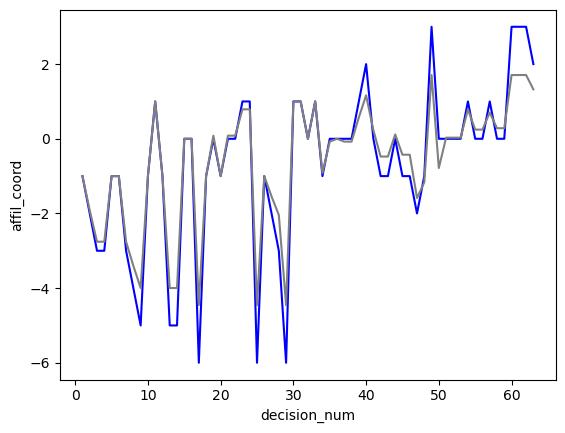

In [68]:
import seaborn as sns
# plot against time
sns.lineplot(data=behavior, x="decision_num", y="affil_coord", color='blue')
# sns.lineplot(data=behavior, x="decision_num", y="affil_coord_cf", color='grey')
sns.lineplot(data=behavior, x="decision_num", y="affil_coord_exponential-decay", color='grey')
# sns.lineplot(data=behavior, x="decision_num", y="power_coord", color='red')
plt.show()